#Import & Function

In [1]:
pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import matplotlib.pyplot as plt
import os
from os import listdir
from os.path import isfile, join
import numpy as np
import cv2
import shutil
import itertools
import random
from PIL import Image
from pathlib import Path
from skimage.color import rgb2gray

from sklearn.model_selection import train_test_split
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import MeanIoU
from keras.models import load_model
from keras import backend as K

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.layers import Activation, MaxPool2D, Concatenate

In [3]:
from numpy.random import seed
seed(1305)
tf.random.set_seed(1305)

In [4]:
def flatten(listOfLists):
    "Flatten one level of nesting"
    return list(itertools.chain.from_iterable(listOfLists))

In [5]:
def searching_all_files(directory: Path):   
    file_list = [] # A list for storing files existing in directories

    for x in directory.iterdir():
        if x.is_file():

           file_list.append(str(x))
        else:

           file_list.append(searching_all_files(directory/x))

    return file_list

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Parameters

In [7]:
lr = 0.1
n_epochs = 370
n_batch = 16
pre_processing = False
HE = True
Prcc = True
Crcc = False
CrCCPrCC = False

# Train/Test

In [8]:
if pre_processing:
  original_dataset = np.load('/content/drive/MyDrive/Bioinfo/Dataset_numpy/Original/train_Pr_clahed.npy')
  original_dataset_test = np.load('/content/drive/MyDrive/Bioinfo/Dataset_numpy/Original/test_Pr_clahed.npy')
  segm_dataset = np.load('/content/drive/MyDrive/Bioinfo/Dataset_numpy/Mask/train_Pr_mask_BIN.npy')
  segm_dataset_test = np.load('/content/drive/MyDrive/Bioinfo/Dataset_numpy/Mask/test_Pr_mask_BIN.npy')

In [9]:
if HE:
  if Prcc:
    original_dataset = np.load('/content/drive/MyDrive/Bioinfo/Dataset_numpy/Original/train_Pr_norm.npy')
    original_dataset_test = np.load('/content/drive/MyDrive/Bioinfo/Dataset_numpy/Original/test_Pr_norm.npy')
    segm_dataset = np.load('/content/drive/MyDrive/Bioinfo/Dataset_numpy/Mask/train_Pr_mask_BIN.npy')
    segm_dataset_test = np.load('/content/drive/MyDrive/Bioinfo/Dataset_numpy/Mask/test_Pr_mask_BIN.npy')
  elif Crcc:
    original_dataset = np.load('/content/drive/MyDrive/Bioinfo/Dataset_numpy/Original/train_Cr_norm.npy')
    original_dataset_test = np.load('/content/drive/MyDrive/Bioinfo/Dataset_numpy/Original/test_Cr_norm.npy')
    segm_dataset = np.load('/content/drive/MyDrive/Bioinfo/Dataset_numpy/Mask/train_Cr_mask_BIN.npy')
    segm_dataset_test = np.load('/content/drive/MyDrive/Bioinfo/Dataset_numpy/Mask/test_Cr_mask_BIN.npy')
  elif CrCCPrCC:
    original_dataset = np.load('/content/drive/MyDrive/Bioinfo/Dataset_numpy/Original/train_PrCr_norm.npy')
    original_dataset_test = np.load('/content/drive/MyDrive/Bioinfo/Dataset_numpy/Original/test_PrCr_norm.npy')
    segm_dataset = np.load('/content/drive/MyDrive/Bioinfo/Dataset_numpy/Mask/train_PrCr_mask_BIN.npy')
    segm_dataset_test = np.load('/content/drive/MyDrive/Bioinfo/Dataset_numpy/Mask/test_PrCr_mask_BIN.npy')

In [10]:
if pre_processing == False and HE == False:
  original_dataset = np.load('/content/drive/MyDrive/Bioinfo/Dataset_numpy/Original/train_Pr_original.npy')
  original_dataset_test = np.load('/content/drive/MyDrive/Bioinfo/Dataset_numpy/Original/test_Pr_original.npy')
  segm_dataset = np.load('/content/drive/MyDrive/Bioinfo/Dataset_numpy/Mask/train_Pr_mask_BIN.npy')
  segm_dataset_test = np.load('/content/drive/MyDrive/Bioinfo/Dataset_numpy/Mask/test_Pr_mask_BIN.npy')

In [11]:
X_train = original_dataset
X_test = original_dataset_test
y_train = segm_dataset
y_test = segm_dataset_test

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.20, random_state = 42)

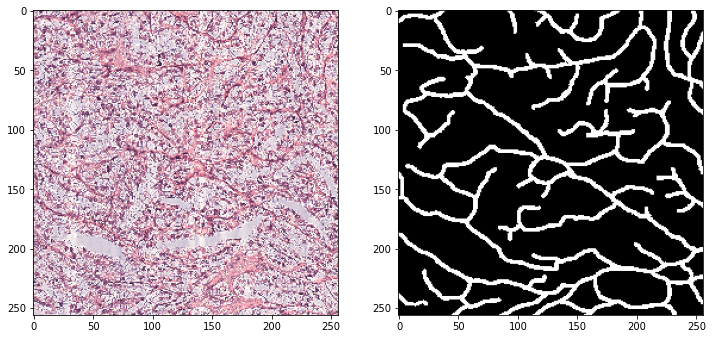

In [13]:
#Sanity check, view few mages
import random

image_number = random.randint(0, len(X_test)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_test[image_number,:,:,:])
plt.subplot(122)
plt.imshow(y_test[image_number,:,:,0],cmap='gray')
plt.show()

# Architecture UNET

In [14]:
def jacard_coef(y_true, y_pred):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

def jacard_coef_loss(y_true, y_pred):
  return -jacard_coef(y_true, y_pred)

In [15]:
# Building Unet by dividing encoder and decoder into blocks


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)  
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   


#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [16]:
IMG_HEIGHT = original_dataset.shape[1]
IMG_WIDTH  = original_dataset.shape[2]
IMG_CHANNELS = original_dataset.shape[3]

opt = keras.optimizers.Adam(learning_rate=lr) 

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
model = build_unet(input_shape, n_classes=1)
model.compile(optimizer=opt, loss=[jacard_coef_loss], metrics=[jacard_coef])

sigmoid


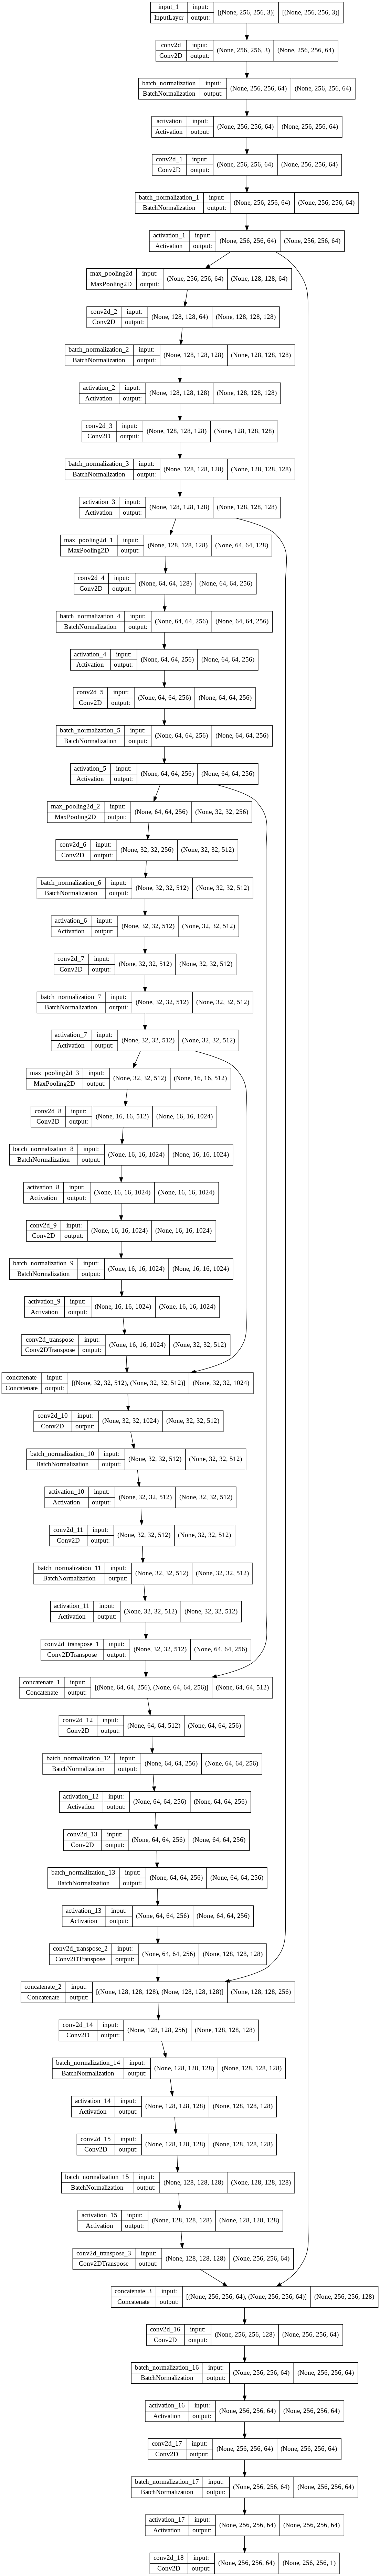

In [17]:
plot_model(model, to_file='unet.png', show_shapes=True)

In [18]:
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
storico = model.fit(X_train, y_train,
                epochs=n_epochs,
                batch_size=n_batch,
                verbose = 1,
                shuffle=True,
                validation_data=(X_valid,y_valid)) 

Epoch 1/370
5/5 [==============================] - 27s 2s/step - loss: -0.1517 - jacard_coef: 0.1517 - val_loss: -0.1309 - val_jacard_coef: 0.1244
Epoch 2/370
5/5 [==============================] - 5s 973ms/step - loss: -0.1888 - jacard_coef: 0.1888 - val_loss: -0.1309 - val_jacard_coef: 0.1244
Epoch 3/370
5/5 [==============================] - 5s 991ms/step - loss: -0.2059 - jacard_coef: 0.2059 - val_loss: -0.1309 - val_jacard_coef: 0.1244
Epoch 4/370
5/5 [==============================] - 5s 1s/step - loss: -0.2204 - jacard_coef: 0.2204 - val_loss: -0.0942 - val_jacard_coef: 0.0763
Epoch 5/370
5/5 [==============================] - 5s 1s/step - loss: -0.2236 - jacard_coef: 0.2236 - val_loss: -1.2356e-05 - val_jacard_coef: 2.0310e-05
Epoch 6/370
5/5 [==============================] - 5s 1s/step - loss: -0.2326 - jacard_coef: 0.2326 - val_loss: -1.2356e-05 - val_jacard_coef: 2.0310e-05
Epoch 7/370
5/5 [==============================] - 5s 995ms/step - loss: -0.2409 - jacard_coef: 0.240

#Losses

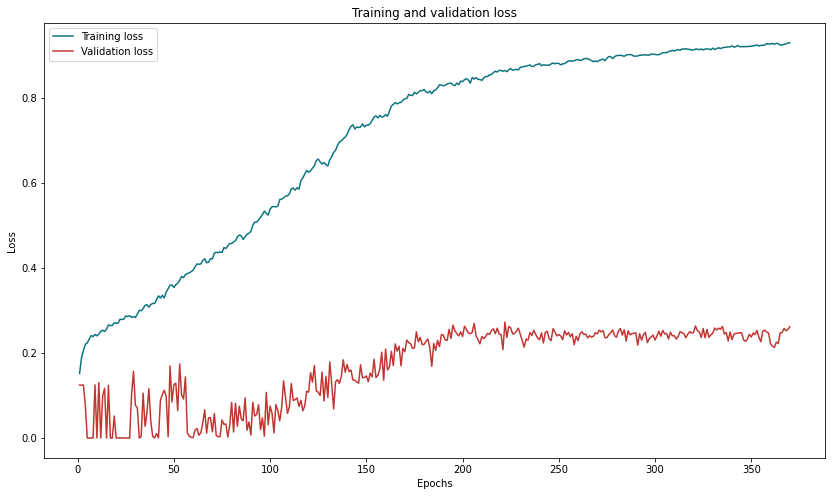

In [ ]:
loss = storico.history['jacard_coef']
val_loss = storico.history['val_jacard_coef']
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(14, 8))
plt.plot(epochs, loss, '#0b747f', label='Training loss')
plt.plot(epochs, val_loss, '#c23631', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#Save the model

In [ ]:
#Save the model for future use
model.save('/content/drive/MyDrive/Bioinfo/modelli_salvati/UNET/FINAL_UNET_Pr_norm_16batch_LR1e-1.hdf5')

#Predict and Plot

In [19]:
#model = load_model('/content/drive/MyDrive/Bioinfo/modelli_salvati/UNET/FINAL_UNET_Pr_norm_16batch_LR1e-1.hdf5', compile=False)

In [20]:
threshold = 0.5
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > threshold

In [21]:
#____________ MEAN IOU__________________
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.5730026


In [22]:
#____________ IOU for each class__________________
values = np.array(IOU_keras.get_weights()).reshape(n_classes,n_classes)
class0_IoU = values[0,0]/(values[0,0]+values[0,1]+values[1,0])
class1_IoU = values[1,1]/(values[1,1]+values[1,0]+values[0,1])

In [23]:
#_____________ IOU____________________
intersection = np.logical_and(y_test,y_pred_thresholded)
union=np.logical_or(y_test,y_pred_thresholded)
iou_score = np.sum(intersection)/np.sum(union)
print("IoU score is:",iou_score)

IoU score is: 0.3171680532008569


In [24]:
#_____________ DICE____________________
intersection = np.logical_and(y_test,y_pred_thresholded)
union=np.logical_or(y_test,y_pred_thresholded)
dice_score = (2*np.sum(intersection))/(np.sum(union)+np.sum(intersection))
print("Dice score is:", dice_score)

Dice score is: 0.4815908682724352


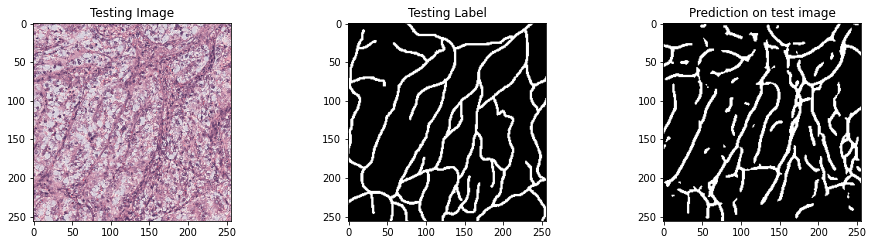

In [25]:
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > threshold).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,:])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)

plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

# Plot all test images

In [ ]:
def plot_images(test_images, ground_truth, prediction, i):
  plt.figure()
  i = i+1
  titolo = 'Testing Image '+str(i)
  plt.title(titolo)
  plt.imshow(test_img[:,:,:])
  plt.show()

def plot_overlapping(ground_truth, prediction, i):
  fig, ax = plt.subplots()
  ax.imshow(ground_truth[:,:,0], cmap='gray')
  ax.imshow(prediction,cmap='gray', alpha=0.6)
  i = i+1
  titolo = 'Masks Overlapping '+str(i)
  ax.set_title(titolo)
  fig.show() 

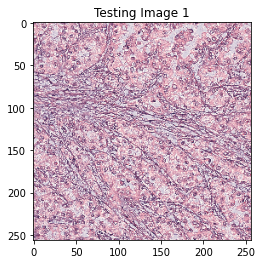

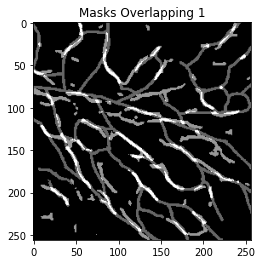

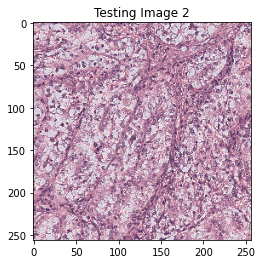

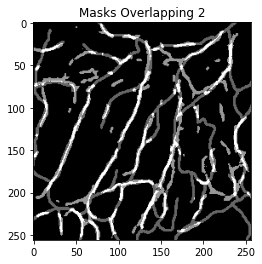

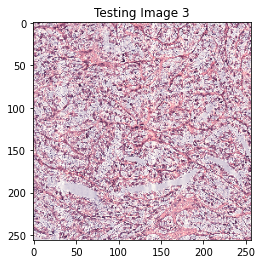

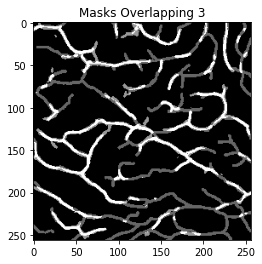

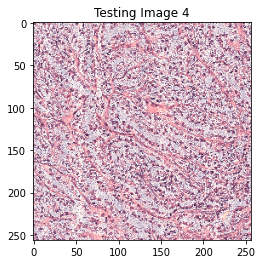

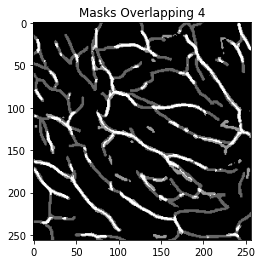

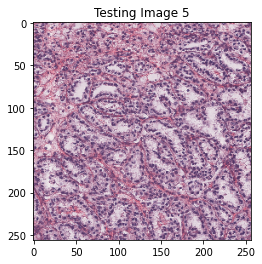

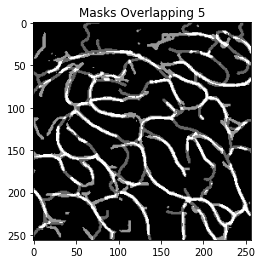

In [ ]:
for i in range(len(X_test)):
  test_img_number = i
  test_img = X_test[test_img_number]
  ground_truth=y_test[test_img_number]
  test_img_input=np.expand_dims(test_img, 0)
  prediction = (model.predict(test_img_input)[0,:,:,0] > threshold).astype(np.uint8)
  
  plot_images(test_img, ground_truth, prediction, i)
  plot_overlapping(ground_truth, prediction, i)